___
# Ciência dos Dados - PROJETO 3 - INSPER

___
## João Pedro Montefeltro Junqueira Meirelles

## Luciana Cocito Alves de Freitas

## Rodrigo Gatti Coutinho

___

___

## INTRODUÇÃO

O objetivo principal desse projeto é, a partir da análise de um uma base de dados, criar modelos preditivos que, baseados em diversas variaveis do banco de dado escolhido, faça uma previsão a respeito de uma variavel quantitativa. A partir desse objetivo, buscamos prever qual seria a renda mensal de uma mulher brasileira de acordo com sua idade, escolaridade e região. Para isso, utilizamos uma PNAD de 2015 e a filtramos, selecionando apenas as variaveis que julgamos necessárias para chegarmos a essa previsão.

___
## MINERANDO DADOS e CARACTERÍSTICAS DO DATASET

 A base de dados utilizada possui centenas de características para serem analisadas. Nesse projeto pretendemos utilizar somente as variáveis: sexo (mulher), rendimento mensal, escolaridade e região. A seguir, filtraremos nosso dataframe de acordo com as variáveis citadas, retirando todas as linhas que possuem informações importantes para análise em questão faltando.

In [119]:
%matplotlib inline
import pandas as pd
import os
import numpy as np
from numpy import arange
from scipy import stats
import matplotlib.pyplot as plt
import sklearn
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn import linear_model

### BASE DE DADOS

In [120]:
#Dataframe: PNAD 2015

dado = pd.read_csv("PES2015.csv")
dado = dado[dado.V8005 >= 18] #separando para pessoas acima de 18 anos
dado.head()

,Unnamed: 0,V0101,UF,V0102,V0103,V0301,V0302,V3031,V3032,V3033,...,V4741,V4742,V4743,V4745,V4746,V4747,V4748,V4749,V4750,V9993
0,0,2015,11,15,1,1,2,27,2,1992,...,1.0,800.0,4.0,5,1.0,2.0,2.0,1.0,800.0,20161117
1,1,2015,11,15,3,1,4,4,5,1992,...,1.0,1150.0,4.0,5,1.0,2.0,2.0,1.0,1150.0,20161117
2,2,2015,11,15,4,1,4,4,1,1980,...,6.0,793.0,4.0,6,1.0,2.0,2.0,1.0,793.0,20161117
3,3,2015,11,15,4,2,2,5,6,1981,...,6.0,793.0,4.0,7,1.0,2.0,2.0,1.0,793.0,20161117
7,7,2015,11,15,4,6,4,8,9,1997,...,6.0,793.0,4.0,5,1.0,2.0,2.0,1.0,793.0,20161117


In [121]:
#reagrupando os tipos de ensino de acordo com a escolaridade desejada (muito baixa, baixa, média e alta)
muito_baixa = [1,2,3]
baixa = [4,5,6,7,8,9]
media = [10]
alta = [11]

i = 0
while i <= 11:
    if i in muito_baixa:
        exec('dado.loc[dado.V4802 ==' + str(i) + ', "V4802"] = "Muito Baixo"')
    elif i in baixa:
        exec('dado.loc[dado.V4802 ==' + str(i) + ', "V4802"] = "Baixo"')
    elif i in media:
        exec('dado.loc[dado.V4802 ==' + str(i) + ', "V4802"] = "Médio"')
    elif i in alta:
        exec('dado.loc[dado.V4802 ==' + str(i) + ', "V4802"] = "Alto"')
    else:
        pass
    i += 1

O critério usado para o reagrupamento de tipos de ensino foi:
<ol><li>Maternal, jardim de infância etc.; Classe de alfabetização; Alfabetização de adultos = Muito baixo</li><li>1ª a 4ª séries do ensino fundamental regular em 8 anos ou de educação de jovens e adultos; 5ª a 8ª séries do ensino fundamental regular em 8 anos ou de educação de jovens e adultos; 1ª série do ensino fundamental regular em 9 anos; 2ª a 5ª séries do ensino fundamental regular em 9 anos ; 6ª a 9ª séries do ensino fundamental regular em 9 anos ; Educação de jovens e adultos não seriado do ensino fundamental = Baixo</li><li>Ensino médio, inclusive pré-vestibular = Médio</li><li>Superior, inclusive mestrado ou doutorado = Alto</li></ol> 

In [122]:
#variáveis a serem utilizadas
dado = dado.loc[:, ["UF", "V0302", "V8005","V4802", "V4718","V4803"]]
dado.to_csv("resumo.csv") #salva em um arquivo no excel
dado.UF = dado.UF.astype('category')
dado.UF.cat.categories = ('Rondônia','Acre','Amazonas','Roraima','Pará','Amapá','Tocantins','Maranhão','Piauí','Ceará','Rio Grande do Norte','Paraíba','Pernambuco','Alagoas','Sergipe','Bahia','Minas Gerais','Espírito Santo','Rio de Janeiro','São Paulo','Paraná','Santa Catarina','Rio Grande do Sul','Mato Grosso do Sul','Mato Grosso','Goiás','Distrito Federal')
dado.V0302 = dado.V0302.astype('category')
dado.V0302.cat.categories = ('Homem', 'Mulher')
dado.loc[(dado.UF=='Rondônia') | (dado.UF=='Acre') | (dado.UF=='Amazonas') | (dado.UF=='Roraima') | (dado.UF=='Pará') | (dado.UF=='Amapá') | (dado.UF=='Tocantins'),'Região'] = 'Norte'
dado.loc[(dado.UF=='Maranhão') | (dado.UF=='Piaui') | (dado.UF=='Caerá') | (dado.UF=='Rio Grande do Norte') | (dado.UF=='Paraíba') | (dado.UF=='Pernambuco') | (dado.UF=='Alagoas') | (dado.UF=='Sergipe') | (dado.UF=='Bahia'),'Região'] = 'Nordeste'
dado.loc[(dado.UF=='Minas Gerais') | (dado.UF=='Espirito Santo') | (dado.UF=='Rio de Janeiro') | (dado.UF=='São Paulo'),'Região'] = 'Sudeste'
dado.loc[(dado.UF=='Paraná') | (dado.UF=='Santa Catarina') | (dado.UF=='Rio Grande do Sul'),'Região'] = 'Sul'
dado.loc[(dado.UF=='Mato Grosso do Sul') | (dado.UF=='Mato Grosso') | (dado.UF=='Goiás') | (dado.UF=='Distrito Federal'),'Região'] = 'Centroeste'

In [123]:
#retirando os dados nulos
dado_not_null = dado[pd.notnull(dado.V0302)& pd.notnull(dado.V8005)& pd.notnull(dado.V4802)& pd.notnull(dado.V4718)]

#Dataframe completa
DFALL = pd.DataFrame({'Região':dado_not_null['Região'],'Sexo':dado_not_null.V0302,'Idade':dado_not_null.V8005,'Ensino':dado_not_null.V4802,'Rendimento_mensal':dado_not_null.V4718.loc[dado.V4718 <= 200000],'Anos_estudo':dado_not_null.V4803.loc[dado.V4803 != 17]})
DFALL = DFALL[DFALL.Sexo == "Mulher"] #análise somente sobre as mulheres
DFALL.head()

,Anos_estudo,Ensino,Idade,Região,Rendimento_mensal,Sexo
2,15.0,Alto,35,Norte,880.0,Mulher
25,14.0,Alto,50,Norte,1800.0,Mulher
54,14.0,Alto,35,Norte,800.0,Mulher
71,11.0,Médio,34,Norte,1600.0,Mulher
198,13.0,Alto,39,Norte,1000.0,Mulher


In [124]:
#DESCRIÇÃO DA RENDA MENSAL NO BRASIL - 2015
DFALL["Rendimento_mensal"].describe()

count     5849.000000
mean      1299.096085
std       1415.047292
min          0.000000
25%        788.000000
50%        950.000000
75%       1500.000000
max      25000.000000
Name: Rendimento_mensal, dtype: float64

### ANÁLISE DESCRITIVA

Porcentagem de mulheres em cada grupo de ensino:

In [125]:
count_ensino = DFALL['Ensino'].value_counts(True)*100
count_ensino

Alto           77.319588
Médio          16.123035
Baixo           5.847558
Muito Baixo     0.709819
Name: Ensino, dtype: float64

Porcentagem de mulheres por idade:

In [126]:
count_idade = DFALL['Idade'].value_counts(True)*100
count_idade

20    7.216495
21    6.455974
18    6.405273
19    5.948961
22    5.864458
23    5.036336
24    4.343417
26    4.326517
25    4.309616
27    3.751901
29    3.380091
28    3.160385
30    3.143485
32    3.042082
31    2.805476
34    2.568869
33    2.484367
35    2.416765
36    2.332263
37    2.197059
40    1.706946
38    1.622444
39    1.537942
43    1.419638
41    1.335136
42    1.115430
46    1.064729
50    0.912625
45    0.895724
48    0.895724
47    0.895724
44    0.777421
49    0.726720
52    0.625317
51    0.591516
53    0.439412
54    0.371810
57    0.321109
55    0.304208
56    0.270407
58    0.169005
61    0.152104
59    0.135204
60    0.118303
63    0.050701
62    0.050701
64    0.050701
67    0.050701
69    0.050701
71    0.033801
68    0.033801
72    0.016900
65    0.016900
66    0.016900
78    0.016900
81    0.016900
Name: Idade, dtype: float64

Porcentagem de mulheres por região:

In [127]:
count_regiao = DFALL['Região'].value_counts(True)*100
count_regiao

Sudeste       26.927333
Nordeste      21.984508
Sul           19.347104
Norte         17.189229
Centroeste    14.551826
Name: Região, dtype: float64

Porcentagem de mulheres por valores de rendimento mensal:

In [128]:
count_rendimento = DFALL['Rendimento_mensal'].value_counts(True)*100
count_rendimento

788.0     14.070781
1200.0     6.770388
1000.0     6.428449
1500.0     4.838434
0.0        4.274235
800.0      3.881005
2000.0     3.846811
900.0      3.812618
400.0      2.803898
500.0      2.325184
1100.0     2.188408
600.0      2.171311
1300.0     2.068730
3000.0     1.897760
1400.0     1.658403
1600.0     1.572918
1800.0     1.538725
300.0      1.504531
2500.0     1.453240
850.0      1.316464
700.0      1.265174
200.0      1.128398
4000.0     0.871944
1700.0     0.735168
2200.0     0.700975
950.0      0.632587
5000.0     0.598393
3500.0     0.598393
450.0      0.564199
350.0      0.564199
            ...    
5400.0     0.017097
844.0      0.017097
622.0      0.017097
2750.0     0.017097
5547.0     0.017097
915.0      0.017097
7050.0     0.017097
1435.0     0.017097
415.0      0.017097
808.0      0.017097
130.0      0.017097
2225.0     0.017097
462.0      0.017097
810.0      0.017097
1053.0     0.017097
4771.0     0.017097
1913.0     0.017097
1368.0     0.017097
1384.0     0.017097


In [129]:
ct1 = pd.crosstab(DFALL['Rendimento_mensal'][DFALL['Rendimento_mensal'] > 0],DFALL['Sexo'][DFALL['Rendimento_mensal'] > 0])
ct1

Sexo,Mulher
Rendimento_mensal,
10.0,1
15.0,1
16.0,1
20.0,1
25.0,1
30.0,6
31.0,1
33.0,1
40.0,2


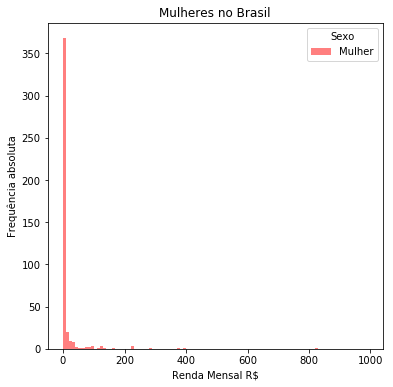

In [130]:
#Salária mínimo em 2015 = 788
faixa = arange(0,1000,10)

ct1.plot.hist(bins=faixa, title='Mulheres no Brasil', figsize=(6,6), color='red', alpha=0.5)
plt.ylabel('Frequência absoluta')
plt.xlabel('Renda Mensal R$')
plt.show()

In [131]:
pd.crosstab(DFALL['Sexo'],DFALL['Ensino'])

Ensino,Alto,Baixo,Muito Baixo,Médio
Sexo,,,,
Homem,0,0,0,0
Mulher,4575,346,42,954


In [132]:
pd.crosstab(DFALL['Rendimento_mensal'],DFALL['Ensino']).head()

Ensino,Alto,Baixo,Muito Baixo,Médio
Rendimento_mensal,,,,
0.0,95,57,13,85
10.0,0,0,0,1
15.0,0,0,0,1
16.0,0,1,0,0
20.0,0,0,1,0


In [133]:
pd.crosstab(DFALL.Sexo[(DFALL['Sexo']=="Mulher")],DFALL['Região'])

Região,Centroeste,Nordeste,Norte,Sudeste,Sul
Sexo,,,,,
Homem,0,0,0,0,0
Mulher,789,1192,932,1460,1049


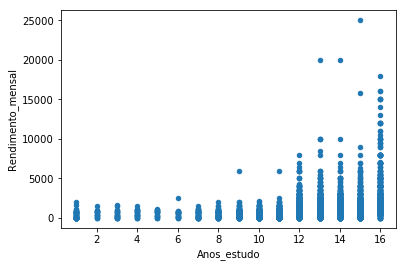

In [134]:
DFALL.plot.scatter('Anos_estudo','Rendimento_mensal')
plt.show()

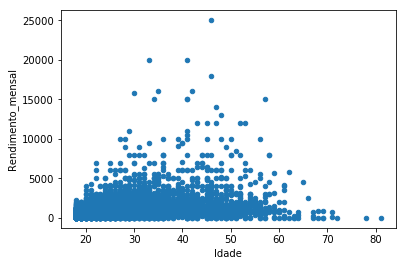

In [135]:
DFALL.plot.scatter('Idade','Rendimento_mensal')
plt.show()

___
## MODELOS DE PREDIÇÃO

o MODELO DE PREDIÇÃO PELA MÉDIA

o MODELO DOS K VIZINHOS MAIS PRÓXIMOS (K-Nearest Neighbors Regression)

o MODELO DE REGRESSÃO LINEAR (Multiple Linear Regression)

In [136]:
#funções para encontrar R2 e RMS
def R2 (n, m, f):
    somaup = ((n - f)**2).sum()
    var = ((n - m)**2).sum()
    r2 = 1 - (somaup/var)
    return r2

def RMS (n, m, f):
    somaup = ((n - f)**2).sum()
    rms = (1/len(n)*somaup)**0.5
    return rms

In [137]:
DFALL['Região'][DFALL['Região'] == 'Nordeste'] = 1
DFALL['Região'][DFALL['Região'] == 'Norte'] = 2
DFALL['Região'][DFALL['Região'] == 'Sudeste'] = 3
DFALL['Região'][DFALL['Região'] == 'Centroeste'] = 4
DFALL['Região'][DFALL['Região'] == 'Sul'] = 5

C:\Users\lucia\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\lucia\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\lucia\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\lucia\Anaconda3\lib\

In [138]:
#separação aleatória da base de dados em treinamento (75%) e teste (25%)
treinamento = DFALL.sample(n=None, frac=0.75, replace=False).reset_index()
teste = DFALL.sample(n=None, frac=0.25, replace=False).reset_index()

#### Predição pela média

Esse modelo prevê um valor se baseando somente na média, e não considera nenhuma outra variável que poderia influenciar o modelo.

Calculamos para a base de dados de treinamento e teste.

In [139]:
print('Rendimento mensal médio (treinamento) = ' + str(treinamento['Rendimento_mensal'].mean()))
print('-------x-------x-------x-------x-------x-------x-------x-------x-------')
print('Rendimento mensal médio (teste) = ' + str(treinamento['Rendimento_mensal'].mean()))

Rendimento mensal médio (treinamento) = 1281.866089728991
-------x-------x-------x-------x-------x-------x-------x-------x-------
Rendimento mensal médio (teste) = 1281.866089728991


In [140]:
print('Valor de R2 (treinamento) = ' + str(R2(treinamento['Rendimento_mensal'],treinamento['Rendimento_mensal'].mean(),treinamento['Rendimento_mensal'].mean())))
print('Valor de RMS (treinamento) = ' + str(RMS(treinamento['Rendimento_mensal'],treinamento['Rendimento_mensal'].mean(),treinamento['Rendimento_mensal'].mean())))
print('-------x-------x-------x-------x-------x-------x-------x-------x-------')
print('Valor de R2 (teste) = ' + str(R2(teste['Rendimento_mensal'],teste['Rendimento_mensal'].mean(),teste['Rendimento_mensal'].mean())))
print('Valor de RMS (teste) = ' + str(RMS(teste['Rendimento_mensal'],teste['Rendimento_mensal'].mean(),teste['Rendimento_mensal'].mean())))

Valor de R2 (treinamento) = 0.0
Valor de RMS (treinamento) = 1358.4206647434942
-------x-------x-------x-------x-------x-------x-------x-------x-------
Valor de R2 (teste) = 0.0
Valor de RMS (teste) = 1332.9144606584912


Devemos considerar que: 
<ol><li>R2 varia de 0 à 1, e quanto mais próximo de 1 maior é a correlação entre os valores analisados;</li><li>quanto menor for o valor de RMS (podendo chegar a zero), melhor a correspondência ao seu valor real.</li></ol> 
Ou seja: esse tipo de predição não é tão indicado para o modelo, pois R2 = 0 e o valor de RMS é alto.

#### Regressão linear

Esse modelo de predição prevê os valores considerando todas as variáveis que utilizamos como características importantes a serem analisadas.

In [144]:
def Regrecao(treinamento,um,dois):
    media_capita = treinamento[um].mean()
    media_anos = treinamento[dois].mean()

    Sxy = 0
    Sxx = 0

    i = 0
    while i < len(treinamento):
        Sxy = Sxy + (treinamento[um][i] - media_capita)*(treinamento[dois][i] - media_capita)
        Sxx = Sxx + (treinamento[um][i] - media_capita)**2
        i += 1

    b1 = Sxy/Sxx
    b0 = media_anos - b1 * media_capita
    diferenca = []
    i = 0
    while i < len(treinamento):
        e = treinamento[dois][i] - (b0 + b1*treinamento[um][i])
        diferenca.append(e)
        i += 1
    
    See = 0
    i = 0
    while i < len(treinamento):
        See += (treinamento[dois][i] - (b0 + b1*treinamento[um][i]))**2
        i += 1
    o = (See/(len(treinamento)-2))**0.5
    ob0 = (o**2*(1/len(treinamento)+media_capita/Sxx))**0.5
    ob1 = (o**2/Sxx)**0.5
    
    print('Sxx = ' + str(Sxx))
    print('Sxy = ' + str(Sxy))
    print('b0^2 = ' + str(b0**2))
    print('b1^2 = ' + str(b1**2))
    print('ob0^2 = ' + str(ob0**2))
    print('ob1^2 = ' + str(ob1**2))
    print('o^2 = ' + str(o**2))
    print('-----x-----x-----x-----x-----x-----x-----x-----x-----')
    
    
    mu = pd.Series(diferenca).mean()
    sigma = pd.Series(diferenca).std()
    x = np.arange(pd.Series(diferenca).min(),pd.Series(diferenca).max(),0.001)
    y = stats.norm.pdf(x, loc=mu, scale=sigma)
    plt.plot(x,y)
    plt.hist(diferenca,bins=30, normed=True, color='r')
    plt.show()
    return None #Sxx, Sxy, b0, b1, ob0, ob1, o

Sxx = 8265882749.03
Sxy = 5344955.8585
b0^2 = 133.701638331
b1^2 = 4.18128494507e-07
ob0^2 = 0.00255564198627
ob1^2 = 1.37120515889e-09
o^2 = 11.3342210682
-----x-----x-----x-----x-----x-----x-----x-----x-----


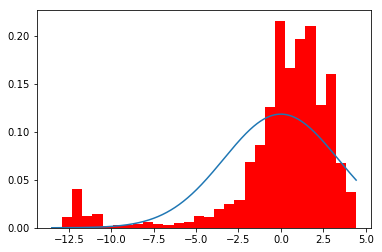

In [145]:
um = 'Rendimento_mensal'
dois = 'Anos_estudo'
Regrecao(treinamento,um, dois)

Sxx = 8265882749.03
Sxy = 14660469.8684
b0^2 = 724.625204032
b1^2 = 3.14569997033e-06
ob0^2 = 0.0198667173309
ob1^2 = 1.06592963493e-08
o^2 = 88.1084938101
-----x-----x-----x-----x-----x-----x-----x-----x-----


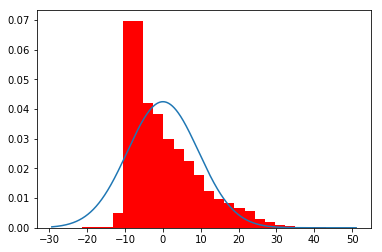

In [146]:
um = 'Rendimento_mensal'
dois = 'Idade'
Regrecao(treinamento,um, dois)

In [147]:
A = treinamento[['Anos_estudo','Região','Idade']]
b = treinamento[['Rendimento_mensal']]

In [148]:
X1 = sm.add_constant(A)
est = sm.OLS(b, X1).fit()

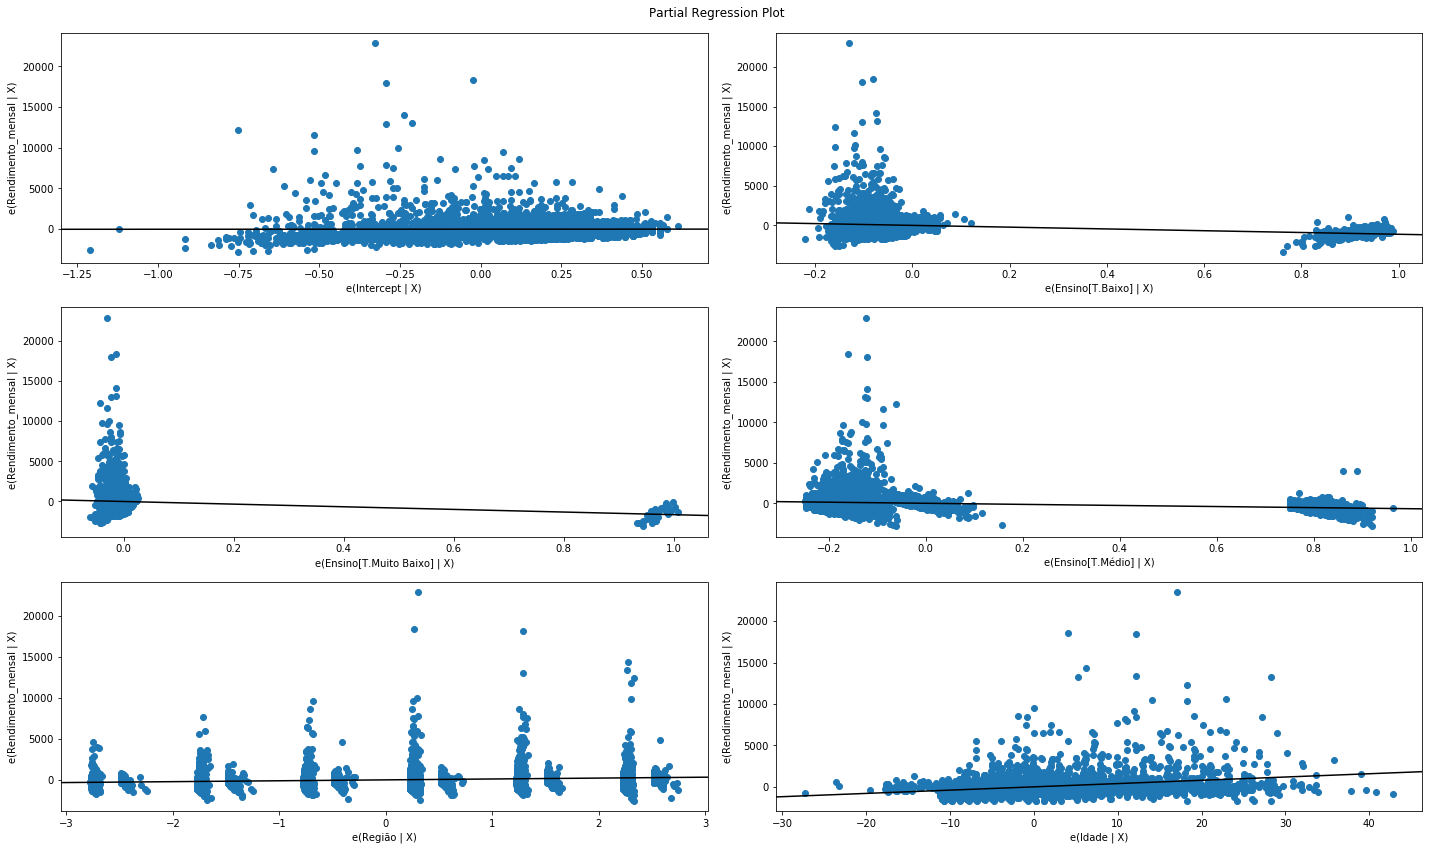

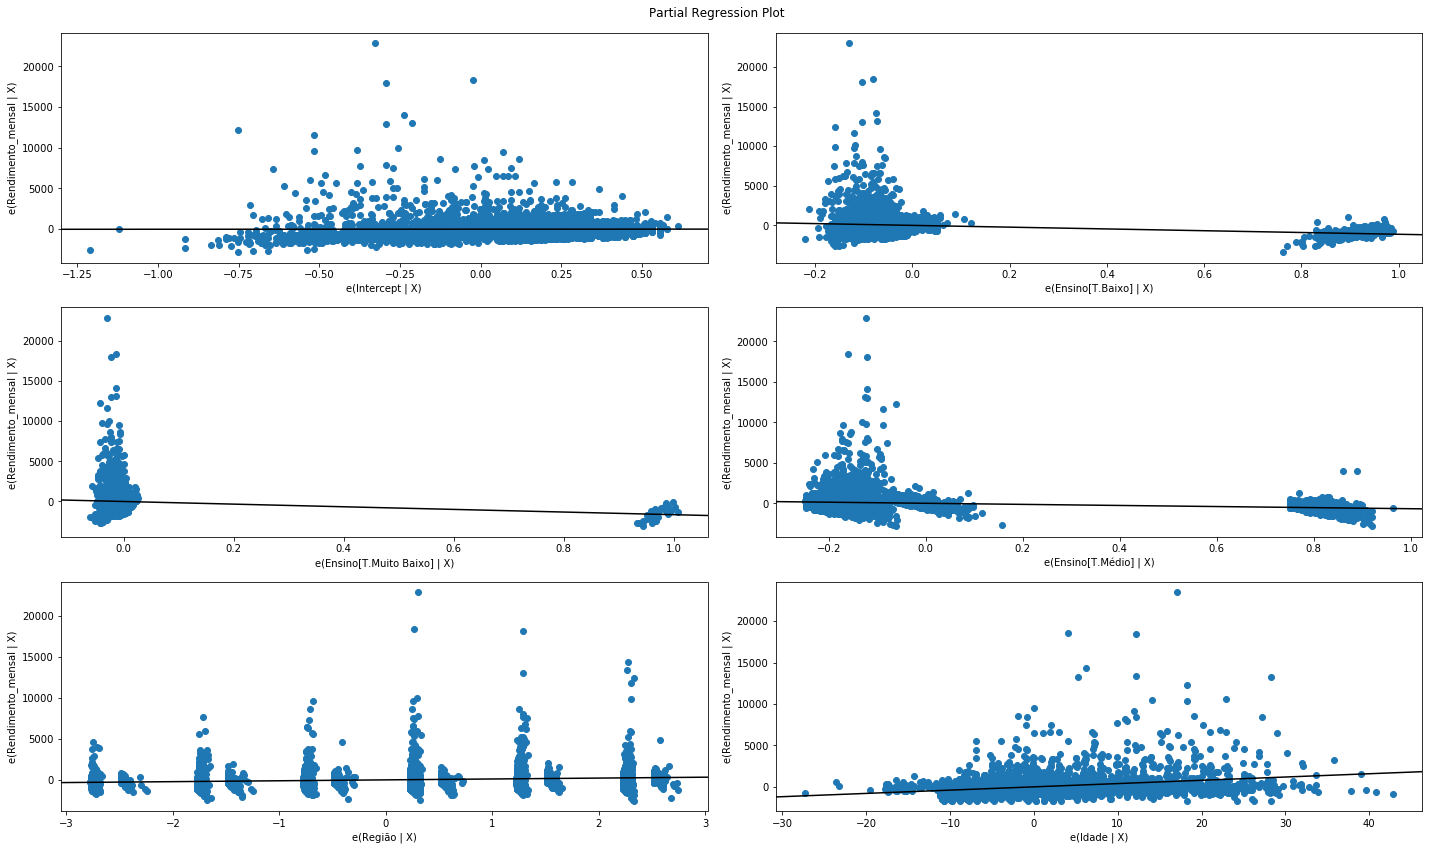

In [157]:
linear = ols("""Rendimento_mensal ~ Ensino + Região + Idade""", data=treinamento).fit()
fig = plt.figure(figsize=(20,12))
fig = sm.graphics.plot_partregress_grid(linear, fig=fig)
fig

In [158]:
gzuis = sm.OLS(b,X1)
xesus = gzuis.fit()
print(xesus.summary())

                            OLS Regression Results                            
Dep. Variable:      Rendimento_mensal   R-squared:                       0.161
Model:                            OLS   Adj. R-squared:                  0.161
Method:                 Least Squares   F-statistic:                     284.2
Date:                Tue, 05 Jun 2018   Prob (F-statistic):          9.71e-169
Time:                        21:56:02   Log-Likelihood:                -37944.
No. Observations:                4438   AIC:                         7.590e+04
Df Residuals:                    4434   BIC:                         7.592e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -1586.2683     99.759    -15.901      

O valor de R2 é dado no sumário pela variável "R-squared", que no caso é: 0,169. O valor se aproxima mais de 1, portanto podemos dizer que existe uma correlação entre as variáveis analisadas e o rendimento mensal. 

A seguir realizaremos a predição do rendimento mensal:

In [159]:


mae_dina = xesus.predict(X1)
print(mae_dina)



0        630.466380
1       1572.267763
2       1970.072561
3       1384.665488
4       1263.343539
5        744.851598
6       2070.401734
7       1605.499218
8       -100.045451
9       1478.057930
10       248.777321
11       517.350775
12       975.864313
13      1796.343748
14       888.591211
15      1458.065129
16      1357.553372
17      1310.448456
18      1484.177269
19       945.692528
20      1614.678228
21       855.359756
22       941.815467
23      1170.585904
24      1136.537057
25       660.638166
26      1384.665488
27      1578.569687
28      1417.714359
29       660.638166
           ...     
4408     895.527942
4409     611.108386
4410     999.099369
4411    1474.180869
4412    1119.603926
4413    2258.369178
4414     939.573188
4415    1594.685427
4416    1504.352655
4417     924.882336
4418     399.271080
4419     536.891353
4420    1879.739789
4421     881.654481
4422     730.978137
4423    1056.200685
4424    1397.721558
4425    1009.095769
4426    1598.562488


In [160]:
def RMS2 (n, y, f):
    soma = ((y-f)**2).sum()
    rms = (soma/n)**(1/2)
    return rms
print('O valor do RMS é:',RMS2(len(treinamento), treinamento.Rendimento_mensal, mae_dina))

O valor do RMS é: 1249.8535980076615


## Hora de testar

In [172]:
x = teste[['Anos_estudo','Região','Idade']]


x = sm.add_constant(x)
predict = xesus.predict(x)
print(predict)

0       1130.417718
1       1598.562488
2       1314.325516
3       1434.012683
4       1701.951330
5        583.361464
6       1957.016491
7       1304.329116
8       1043.144615
9       1447.886144
10      1424.833674
11       771.146323
12        14.339767
13       178.072181
14      1919.907975
15      1326.564196
16      1240.743290
17      1243.168154
18      1105.730465
19      1675.656605
20      1685.835590
21        94.676139
22      1100.245932
23      1347.556972
24      1079.435740
25      1447.886144
26      1284.153731
27       968.927583
28      1779.410617
29      1317.385186
           ...     
1449    1361.430433
1450    1733.123091
1451    1542.278562
1452    1179.764913
1453    1233.989145
1454     730.978137
1455     134.844325
1456    1035.390494
1457     764.209593
1458    1152.835382
1459     888.591211
1460    1793.101493
1461    2823.783451
1462     744.851598
1463    1100.245932
1464    2298.537364
1465    1180.582304
1466    1785.529956
1467    1277.217000


In [173]:
print('O valor de RMS para o teste é:',RMS2(len(teste),teste['Rendimento_mensal'],predict))
print('O valor de R2 para o teste é:',R2(teste['Rendimento_mensal'],predict,teste.Rendimento_mensal.mean()))

O valor de RMS para o teste é: 1219.2767329562253
O valor de R2 para o teste é: -0.204906684859534


### Interpretando

Obtivemos um R2 negativo, isso quer dizer que o modelo de predição por regressão linear está sendo menos eficiente do que a predição pela média. Ou seja, caso queiramos prever o rendimento mensal das mulheres de acordo com as características citadas anteriormente, o melhor modelo a ser utilizado para sua predição é pela média. Observamos que não há uma relação direta entre os anos de ensino, idade, região e renda mensal.

In [177]:
print('Relação entre RMS de treinamento sobre teste da pela média: ' + str(float(RMS(treinamento['Rendimento_mensal'],treinamento['Rendimento_mensal'].mean(),treinamento['Rendimento_mensal'].mean())/RMS(teste['Rendimento_mensal'],teste['Rendimento_mensal'].mean(),teste['Rendimento_mensal'].mean()))))
print('Relação entre RMS de treinamento sobre teste da regressão linear: ' + str(float(RMS2(len(treinamento), treinamento.Rendimento_mensal, mae_dina)/RMS2(len(treinamento),treinamento['Rendimento_mensal'],predict))))

Relação entre RMS de treinamento sobre teste da pela média: 1.0196989638675045
Relação entre RMS de treinamento sobre teste da regressão linear: 1.5823799510331804


Podemos analisar a qualidade dos modelos de predição feitos por meio do coeficiente "RMS", o qual é verificado pela divisão de seus valores de treinamento pelos de teste. Sabemos que, quanto mais próximo de 1 melhor é o modelo utilizado. Isso se dá pela qualidade da amostra para explicar o nosso Dataframe como um todo. Pudemos observar que no caso da regressão linear podemos considerar seu resultado como overfiting, isso implica na sua capacidade de generalizar o seu resultado obtido da amostra. Mais uma vez, isso nos mostra que as característcas usadas para avaliar o rendimento mensal não possuem uma correlção forte. Já no modelo de predição pela média, o valor se aproxima de 1. Ou seja, é o modelo mais adequado para utilizarmos.

___
## CONCLUSÃO

Sabemos por lógica e pela análise dos gráficos scatters acima que existe uma relação entre o rendimento mensal de uma mulher, sua idade, região de moradia e anos de estudo. Porém, concluímos que, por meio do R2 (Erro quadrático) negativo, essa relação é bem pequena. Então, qual seria o motivo real dessa relação não existir no nosso estudo, sabendo que a renda feminina não muda durante o tempo para maioria das mulheres? 
Isso se dá pelo fato de não termos uma sociedade principalmente meritocrática, e sim uma sociedade corporativista, onde o governo acaba impedindo que pessoas, indivíduos, criem empresas e assim gerem empregos, e que, consequentemente, existam empresas competindo entre si, gerando riqueza. 
Aí se encontra a base do problema. A riqueza no Brasil é gerada tão devagar que está acompanhando a taxa de crescimento populacional, e isso impede que pessoas consigam ganhar mais pelo trabalho que elas exercem. Assim, existem poucas pessoas que ganham muito, pois essas se referem às poucas empresas que conseguiram sobreviver à regulação estatal do mercado. Ainda mais no caso das mulheres, que em suma maioria ganham muito menos que os homens na ocupação de um mesmo cargo.
Logo, concluímos que quando for permitido a criação de empresas sem a regulação estatal, consegue-se um modelo de mercado que irá beneficiar o bom empregado e a boa empresa. A partir deste, o erro encontrado não mais existiria.

___
## REFERÊNCIAS BIBLIOGRÁFICAS

https://ensinandomaquinasblog.wordpress.com/2017/12/15/modelos-preditivos-de-notas-de-redacao-do-enem-2015/
https://machinelearningmastery.com/overfitting-and-underfitting-with-machine-learning-algorithms/
https://towardsdatascience.com/simple-and-multiple-linear-regression-in-python-c928425168f9
https://stats.stackexchange.com/questions/12900/when-is-r-squared-negative 
http://www.fairlynerdy.com/what-is-r-squared/
    